<center><h1> Tutorial: MaxCut and QAOA using Pennylane <h1><center>

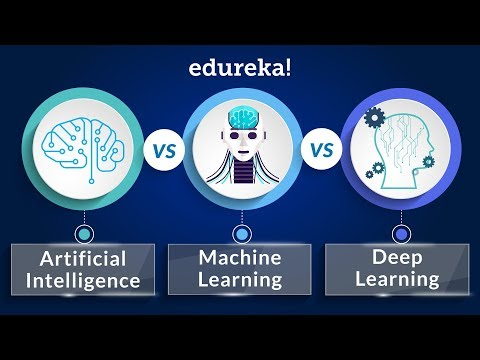

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('WSbgixdC9g8', width=800, height=300)

**Uncomment and execute the cell below if you do not have Pennylane installed in your computer**

In [33]:
#import sys
#!{sys.executable} -m pip install pennylane
#!{sys.executable} -m pip install pennylane-qulacs["cpu"]

<h2>1. The MAXCUT problem <h2>

In this question we will formulate the MAXCUT problem as a combinatorial optimization problem. With this knowledge we will establish the cost Hamiltonian for the problem, that is, the Hamiltonian whose ground state we need to find in order to solve the MAXCUT problem using QAOA. This step is basically transforming the classical problem into a quantum problem, so that we can use a quantum computer to solve it.

**The following libraries will be useful in what follows. Please do not forget to import them**

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import networkx as nx
from matplotlib import pyplot as plt

The maxcut problem is an optimization problem in which the vertices of a graph are partitioned into two sets. That partition will be a maxcut if the number of edges between elements of different partitions is maximal. To see an example, let us consider the following graph in the shape of a "house". The *networkx library* allows us to draw graphs with vertices and edges. As input, we need a list of edges, in this case:

In [2]:
list_of_edges=[(0,1),(0,2),(1,3),(1,2),(1,3),(2,4),(3,4)]

Then we can plot the graph:

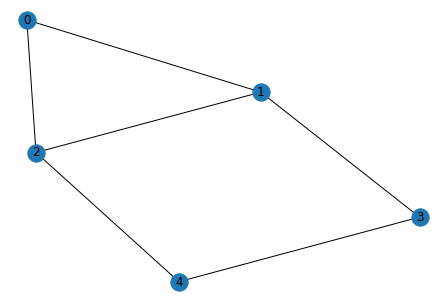

In [3]:
graph=nx.Graph(list_of_edges)

nx.draw(graph, with_labels=True)
plt.show()

Now, let us choose a partition of the vertices. This means we split them into two sets $P_1$ and $P_2$, say $P_1=\left\lbrace 2,3\right\rbrace$, $P_2=\left\lbrace 0,1,4\right\rbrace$. Let us plot the graph again, with different vertex coloring according to the partition we chose:

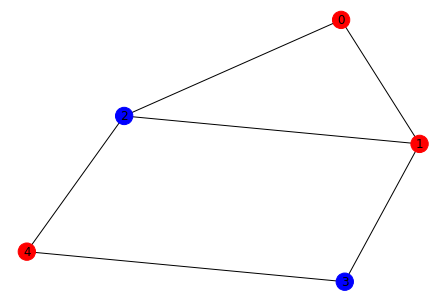

In [4]:
color_map = []
for node in graph:
    if node == 2 or node ==3:
        color_map.append('blue')
    else: 
        color_map.append('red')      
nx.draw(graph, node_color=color_map, with_labels=True)
plt.show()

Then the following edges: (0,2), (1,2), (2,4), (1,3) and (3,4) join vertices of different color. Thinking about it a little, there will always be at least a pair of connected vertices in the same partition. Therefore, this partition that we chose is a MAXCUT, since there are five edges between elements of different partitions, and there cannot be six. So how do we solve this problem in general? Are we supposed to guess every time? Or **is there a general mathematical method to solve it?** This problem is not easy to solve in the general case, but at least we can give a **mathematical formulation of it**. The problem will amount to **maximizing the function**:

$$C(\vec{s})=\frac{1}{2}\sum_{(i,j)\in E}\left(1-s_i s_j\right)$$

Here $E$ is the set of edges, and $s_k$ is a function that takes the value $+1$ if $k\in P_1$, and the value $-1$ if $k\in P_2$. Therefore, each term $\frac{1}{2}\left(1-s_i s_j\right)$ will be 1 if the vertices $i$ and $j$ are in different partitions, and will be zero if they are in the same partition. This function counts the edges between partition and is precisely what we need to maximize. Since $s_k$ is a discrete function, this is a combinatorial optimization problem.


**How do we turn this into a problem that quantum computers can solve?** As explained in the introductory video, we need to map it to a Hamiltonian, known as the **problem Hamiltonian or cost Hamiltonian**. In this case, it is given by

$$ \hat{C}=-\frac{1}{2}\sum_{(i,j)\in E}\left(\mathbb{1}-Z_i Z_j\right)$$

Here $Z_k$ is the Pauli z-matrix, $\mathbb{1}$ represents $m$ tensor product of the identity, where $m$ is the number of vertices, and $Z_i Z_j$ is a product of $m$ identities with Pauli z-matrices introduced in the $i$-th and $j$-th positions. You can show that, for $\left\lvert x \right\rangle$ in the basis $\mathcal{B}=\left\lbrace\left\lvert 00000 \right\rangle, \left\lvert 00001 \right\rangle, \left\lvert 00010 \right\rangle, \ldots \left\lvert 11111 \right\rangle\right\rbrace$, we have 

$$\hat{C}\left\lvert x \right\rangle = -C(x)\left\lvert x \right\rangle.$$

So finding a maximum for $C$ corresponds to finding the eigenstate of $\hat{C}$ with minimum eigenvalue (note the minus sign), that is, the ground state. One feature of **Pennylane** is that it **can find this cost Hamiltonian for any graph that you put in**. This is done with the *qaoa* module:

In [5]:
H_cost, H_mixer = qaoa.maxcut(graph)

This defines the cost and mixer Hamiltonians. We will see what the mixer Hamiltonian is in section 2. For now, let us see what Pennylane gives us as the cost Hamiltonian:

In [6]:
print(H_cost)

  (-3.0) [I0]
+ (0.5) [Z0 Z1]
+ (0.5) [Z0 Z2]
+ (0.5) [Z1 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z2 Z4]
+ (0.5) [Z3 Z4]


Exactly as expected.

<h2> 2. Preparing the QAOA ansatz state <h2>

In this part we will learn how to draw quantum circuits with Pennylane. Then we will use this knowledge to implement the necessary quantum circuit for QAOA. 

As explained in the video, QAOA is an algorithm that allows us find the ground state of the problem Hamiltonian. The reason that this works is the **adiabatic theorem**, which we now recall. It states that if the ground state of the Hamiltonian $H_0$ evolves under the time dependent Hamiltonian 

$$H(t)=(1-t)H_0 + t H_1, \quad t\in [0,1],$$

then at $t=1$ the state will be in the ground state of $H_1$ if the variation occurs slowly enough. **Therefore, a trick to find the ground state for a complicated Hamiltonian $H_1$ is to start with the ground state of a simple Hamiltonian $H_0$ and let it evolve adiabatically under $H(t)$.**

For our purposes, we will take $H_0=\sum_j X_j$, which has the simple ground state $\left\lvert+\right\rangle^{\otimes n}$. We take $H_1$ to be the negative of problem Hamiltonian that we derived in the first section of this tutorial, up to a constant:

$$H_1=\frac{1}{2}\sum_{i,j\in E}\left(Z_i Z_j\right)$$

QAOA does not implement adiabatic evolution. Instead, it gives us a "shortcut" than we can implement by iterating a process with a few gates. The more times we iterate this process, the better approximation we will get to the ground state of $H_1$. The process involves the following steps:

**1.** Choose two $p$-dimensional real vectors $\mathbf{\beta}$ and $\mathbf{\gamma}$ with components $\beta_i$ and $\gamma_i$ respectively, $i=1,\ldots p$. 

**2.** Apply the operator $e^{-i\beta_1 B} e^{-i\beta_1 C}$ the ground state $\left\lvert+\right\rangle^{\otimes n}$ of $H_0$, where $B=H_0$ is the mixer Hamiltonian and $C=H_1$ is the cost Hamiltonian. 

**3.** Iterate this process $p$ times, for each component $\beta_i$, $\gamma_i$, thus preparing the *ansatz state*

$$\left\lvert\psi(\beta,\gamma)\right\rangle=e^{-i\beta_1 B} e^{-i\gamma_p C}\ldots e^{-i\beta_1 B} e^{-i\gamma_p C}\left\lvert+\right\rangle^{\otimes n}$$

**4.** Use gradient descent or some other classical algorithm to optimize $\left\langle\psi(\beta,\gamma)\right\rvert C\left\lvert\psi(\beta,\gamma)\right\rangle$ and find parameters $\beta$ and $\gamma$ that better approximate the optimum.

**5.** Update parameters $\beta$ and $\gamma$ and repeat steps **1.** to **4.** until we find the parameters that give us an optimum.

**6.** Read off the solution to the optimization problem from the obtained ground state.

The good news is that Pennylane can simulate QAOA and give us the optimal parameters without too much effort. Nonetheless, it is instructive to gain more insight about the process. Let us focus on the following question: **How can we build a quantum circuit that implements steps 2 and 3?**

It can easily be shown that $e^{-i\beta X_i}$ is equal to $H e^{-i\beta Z_i}H$, where $H$ is the Hadamard gate. Therefore, the corresponding circuit for this process consists of two Hadamard gates and a rotation around the $z$-axis:

![title](img/circuit2.png)

Let us implement this circuit on Pennylane. To do this, we must first tell Pennylane that we are creating a device, which we call *dev*:

In [7]:
dev=qml.device("default.qubit", wires=1)

Which simply tells Pennylane that we are working with one wire and with pure qubits. Now we define the circuit. The function must be defined right below *@qml.qnode(dev)*

In [8]:
@qml.qnode(dev)
def circuit(beta):
    qml.Hadamard(wires=0)
    qml.RZ(2 * beta, wires=0)
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))

Inside the function, which depends on the parameter $\beta$, we write the gates in order. The *wires* argument simply tells us the wire number that the gate is at (starting from zero). Since there is only one wire, all of them read *wires=0*. We finally return the expectation value of $Z$. The inputs are, by default, the $\left\lvert 0 \right\rangle$ qubit (in the Z basis). Pennylane allows us to draw the circuit. For example for $\beta=0.5$. 

In [9]:
circuit(0.5)
print(circuit.draw())

 0: ──H──RZ(1)──H──┤ ⟨Z⟩ 



To implement the operator $e^{-i\gamma Z_i Z_j}$, all we need to do is to combine a rotation around the $z$-axis with two CNOT gates, in the following way:

![title](img/circuit1.png)

Feel free to prove thaty this is indeed the case if you have the time. Let us implement this as above. In this case we have two wires so we define:

In [10]:
dev1 = qml.device("default.qubit", wires=2)

In [11]:
@qml.qnode(dev1)
def circuit1(gamma):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0,1])
    qml.RZ(2 * gamma, wires=1)
    qml.CNOT(wires=[0,1])
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

Observe that we specified each gate together with the wire, and we returned a list of expectation values. Pauli Z(i) gives the expectation value of $Z$ in the $i$-th wire. The Hadamard gates at the beginning are set up to bring the $\left\lvert 0\right\rangle$ state to the $\left\lvert +\right\rangle$ state. Let us check that we defined the correct circuit. For $\gamma =0.5$:

In [12]:
circuit1(0.5)
print(circuit1.draw())

 0: ──H──╭C─────────╭C──┤ ⟨Z⟩ 
 1: ──H──╰X──RZ(1)──╰X──┤ ⟨Z⟩ 



We can now generalize this for the case of more than two qubits. Let us choose *n_qubits=5*, which corresponds to the number of vertices in MAXCUT. The same code can be used with little variation for any other number of qubits and list of edges in our graph. (Code adapted from https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html).

In [13]:
n_qubits = 5

dev2 = qml.device("default.qubit", wires=n_qubits)

def B(beta): #We simply implement what we did before in the form of a function
    for wire in range(n_qubits):
        qml.Hadamard(wires=wire)
        qml.RZ(2 * beta, wires=wire)
        qml.Hadamard(wires=wire)
            
def C(gamma,edges): #Again define a function for the Cost Hamiltonian term
    for edge in edges:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[int(wire1), int(wire2)]) #Note that the CNOTs give the interactions between wires, given by the edges.
        qml.RZ(gamma, wires=int(wire2))
        qml.CNOT(wires=[int(wire1), int(wire2)])
        
        """
        Note the int before the wires, for some reason Pennylane plots poorly if that is not done.
        This is a known issue which will hopefully be fixed in the upcoming versions.
        """

@qml.qnode(dev2)
def circuit2(beta,gamma,edges,layers=1): #layers is the number p that we choose. Larger is better to approximate the adiabatic path
    
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
       
    for n in range(layers):
      
        C(gamma[n],edges) 
        B(beta[n])
    
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    

For example, with two layers, the QAOA circuit is:

In [14]:
circuit2([0.5,0.6],[0.8,0.4],list_of_edges,2)
print(circuit2.draw())

 0: ──H──╭C───────────╭C──────╭C───────────────╭C───H──RZ(1)─────H────────────────────────────────────────────╭C───────────╭C──────╭C───────────────╭C───H──RZ(1.2)───H───────────────────────────────────────────────────────────┤ ⟨Z⟩ 
 1: ──H──╰X──RZ(0.8)──╰X──╭C──│────────────╭C──│───╭C───────────╭C──────╭C───────────────╭C───H──RZ(1)─────H──╰X──RZ(0.4)──╰X──╭C──│────────────╭C──│───╭C───────────╭C──────╭C───────────────╭C───H──RZ(1.2)───H─────────────────┤ ⟨Z⟩ 
 2: ──H───────────────────│───╰X──RZ(0.8)──│───╰X──╰X──RZ(0.8)──╰X──╭C──│────────────╭C──│────H──RZ(1)─────H───────────────────│───╰X──RZ(0.4)──│───╰X──╰X──RZ(0.4)──╰X──╭C──│────────────╭C──│────H──RZ(1.2)───H─────────────────┤ ⟨Z⟩ 
 3: ──H───────────────────╰X──────RZ(0.8)──╰X───────────────────────│───╰X──RZ(0.8)──│───╰X──╭C───────────╭C───H──RZ(1)─────H──╰X──────RZ(0.4)──╰X───────────────────────│───╰X──RZ(0.4)──│───╰X──╭C───────────╭C──H──RZ(1.2)──H──┤ ⟨Z⟩ 
 4: ──H─────────────────────────────────────────────────────────────

Therefore, Pennylane can give us the gates needed of QAOA given the edges, vertices, ansatz parameters, and the number of steps we would like for the approximation. 

This is all good, but **is there a way for Pennylane to give us the QAOA circuit without this much work?** The answer, of course, is yes. The cost layer comes built in:

In [15]:
dev3=qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev3)
def circuit3(gamma):
    qaoa.cost_layer(gamma,H_cost)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

The *cost_layer* function calls the cost Hamiltonian we calculated in section 1. We can plot the layer:

In [39]:
circuit3(0.5)
print(circuit3.draw())

 0: ──╭RZ(0.5)────────────╭RZ(0.5)────────────────────────────────┤ ⟨Z⟩ 
 1: ──╰RZ(0.5)──╭RZ(0.5)──│─────────╭RZ(0.5)──────────────────────┤ ⟨Z⟩ 
 2: ────────────│─────────╰RZ(0.5)──╰RZ(0.5)──╭RZ(0.5)────────────┤ ⟨Z⟩ 
 3: ────────────╰RZ(0.5)──────────────────────│─────────╭RZ(0.5)──┤ ⟨Z⟩ 
 4: ──────────────────────────────────────────╰RZ(0.5)──╰RZ(0.5)──┤ ⟨Z⟩ 



The mixer layer also comes predefined:

In [16]:
dev4=qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev4)
def circuit4(beta):
    qaoa.mixer_layer(beta,H_mixer)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [17]:
circuit4(0.5)
print(circuit4.draw())

 0: ──H──RZ(1)──H──┤ ⟨Z⟩ 
 1: ──H──RZ(1)──H──┤ ⟨Z⟩ 
 2: ──H──RZ(1)──H──┤ ⟨Z⟩ 
 3: ──H──RZ(1)──H──┤ ⟨Z⟩ 
 4: ──H──RZ(1)──H──┤ ⟨Z⟩ 



It is also possible to stack these layers using the layer command. Let us use what we just learned to easily build a QAOA circuit with a number of layers *n_layers*, which we can use later to optimize the parameters:

In [31]:
def qaoa_layer(beta,gamma):
#This defines a layer       
    qaoa.cost_layer(gamma,H_cost)
    qaoa.mixer_layer(beta,H_mixer)
    
def qaoa_circ(params, n_layers=2,**kwargs):
#This defines the entire cricuit
    for wire in range(n_qubits):
        qml.Hadamard(wires=wire)
    qml.layer(qaoa_layer, n_layers, params[0], params[1])

The params argument is a list of vectors $[\beta,\gamma]$. As a sanity check, let us draw it for some values of the parameters:

In [32]:

dev5=qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev5)
def circuit5(params, n_layers=2):
    qaoa_circ(params,n_layers)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [33]:
circuit5([[0.5,0.2],[0.3,0.6]],2)
print(circuit5.draw())

 0: ──H──╭RZ(0.3)────────────╭RZ(0.3)───H─────────RZ(1)─────H───────────────╭RZ(0.6)──╭RZ(0.6)───H─────────RZ(0.4)───H───────────────────────────────────────┤ ⟨Z⟩ 
 1: ──H──╰RZ(0.3)──╭RZ(0.3)──│─────────╭RZ(0.3)───H─────────RZ(1)────H──────╰RZ(0.6)──│─────────╭RZ(0.6)──╭RZ(0.6)───H─────────RZ(0.4)──H────────────────────┤ ⟨Z⟩ 
 2: ──H────────────│─────────╰RZ(0.3)──╰RZ(0.3)──╭RZ(0.3)───H────────RZ(1)───H────────╰RZ(0.6)──│─────────╰RZ(0.6)──╭RZ(0.6)───H────────RZ(0.4)──H───────────┤ ⟨Z⟩ 
 3: ──H────────────╰RZ(0.3)──────────────────────│─────────╭RZ(0.3)──H───────RZ(1)─────H────────╰RZ(0.6)────────────│─────────╭RZ(0.6)──H────────RZ(0.4)──H──┤ ⟨Z⟩ 
 4: ──H──────────────────────────────────────────╰RZ(0.3)──╰RZ(0.3)──H───────RZ(1)─────H────────────────────────────╰RZ(0.6)──╰RZ(0.6)──H────────RZ(0.4)──H──┤ ⟨Z⟩ 



<h2>3. Parameter optimization and ground state <h2>

We will now focus on steps **4**, **5** and **6** introduced in the previous question. Of course, there would be a lot of coding to do here but, thankfully, Pennylane has this already implemented for us in the *qaoa* module. We can simulate the circuit using *qulacs.simulator* (uncomment relevant section at the beginning of the notebook if you don't have this plugin installed. The code that follows is adapted from https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html). 

In [34]:
dev6 = qml.device('qulacs.simulator', wires=range(n_qubits))
cost_function = qml.ExpvalCost(qaoa_circ, H_cost, dev6)

This tells Pennylane to evaluate the expectation value of the cost Hamiltonian at the end of the circuit. This is the function that we have to minimize according to step **4. Why is this the case?** The reason is that the ground state energy is the minimum for the real function $\left\langle \psi\right\rvert C \left\lvert \psi\right\rangle$. To minimize this function, let us use gradient descent, which is already implemented in Pennylane:

In [35]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = [[0.5, 0.5], [0.5, 0.5]]

The following implements 70 steps of gradient descent, and gives the Optimal parameters for QAOA. This is what step **5.** tells us to do.

In [36]:
for i in range(steps):
    params = optimizer.step(cost_function, params)

print(params)

Optimal Parameters
[[0.47568128061213627, 0.6884927149808401], [0.7281412058578425, -0.27612197994427584]]


Then we can define a new circuit that computes the probabilities in the computational basis. We expect that the states with the largest probabilities are the ground states, since QAOA must yield a state that is approximately this ground state. 

In [39]:
@qml.qnode(dev6)
def probability_circuit(beta,gamma):
    qaoa_circ([beta, gamma])
    return qml.probs(wires=range(n_qubits))


probs = probability_circuit(params[0], params[1])

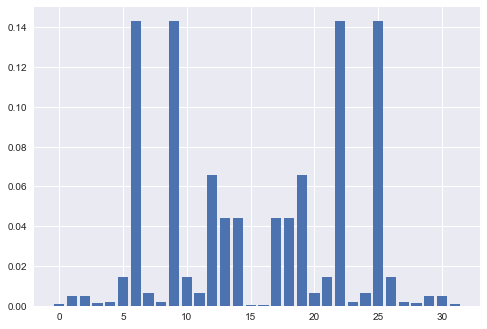

In [42]:
plt.style.use("seaborn")
plt.bar(range(2 ** n_qubits), probs)
plt.show()

To see what kets the maxima correspond to, we transform to binary

In [46]:
bin(6),bin(9),bin(22),bin(25)

('0b110', '0b1001', '0b10110', '0b11001')

We can now complete step **6.** by reading off the ground states: $\left\lvert 00110\right\rangle$, $\left\lvert 01001\right\rangle$, $\left\lvert 10110 \right\rangle$, $\left\lvert 11001 \right\rangle$, precisely as we had derived in section 1, up to colour and mirror symmetries. 